# Import modules

In [1]:
import os
import numpy as np
import scanpy as sc
import anndata
import pandas as pd
import matplotlib as mpl
# enables correct plotting of text
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)

In [2]:
import session_info
session_info.show()

In [3]:
import importlib.util
import sys

spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/tissueaxis.py")
tissueaxis = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = tissueaxis
spec.loader.exec_module(tissueaxis)

In [4]:
sc.settings.set_figure_params(dpi=80,dpi_save=300)

In [5]:
figdir = '/nfs/team205/heart/fetal_ms_figures/raw_plots_kk'

# Functions

In [6]:
# This function selects the data for multiple slides from the spatial anndata object.
# Modified `select_slide` in cell2loc for multiple slides

# @param adata: anndata object with multiple spatial experiments
# @param s: list of selected slides
# @param s_col: column in adata.obs listing experiment name for each location

def select_multislide(adata, s, s_col='sample'):

    slides = adata[adata.obs[s_col].isin(s), :]
    s_keys = list(slides.uns['spatial'].keys())
    
    uns_dict = {}
    for ss in s:
        s_spatial=np.array(s_keys)[[ss in k for k in s_keys]][0]
        uns_dict[s_spatial]=slides.uns['spatial'][s_spatial]
    
    slides.uns['spatial'] = uns_dict

    return slides

# Read in adata

* Only OCT sections, for consistency

In [7]:
adata_oct_healthy = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium-OCT_foetal_raw.h5ad')
print(adata_oct_healthy.shape)
adata_oct_healthy_LV = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium-OCT-LV_foetal_raw.h5ad')
print(adata_oct_healthy_LV.shape)

(14261, 33538)
(6767, 33538)


In [8]:
# concatenate oct adata
adata_oct = adata_oct_healthy.concatenate(
    [adata_oct_healthy_LV],
    batch_key=None,
    index_unique=None,
    join="inner"
)

In [9]:
# log-normalise
sc.pp.normalize_total(adata_oct, target_sum=1e4)
sc.pp.log1p(adata_oct)

# sc.pp.normalize_total(adata_ffpe, target_sum=1e4)
# sc.pp.log1p(adata_ffpe)

# reset var_names
adata_oct.var.set_index('SYMBOL',inplace=True)
# adata_ffpe.var.set_index('SYMBOL',inplace=True)

# Add axis

In [10]:
!ls /nfs/team205/heart/visium_axis/foetal/transmural_LV

BHF_F_Hea13295830.csv	HCAHeartST10317186.csv	HCAHeartST13162330.csv
BHF_F_Hea13295831.csv	HCAHeartST11605165.csv	HCAHeartST13162331.csv
HCAHeartST10317184.csv	HCAHeartST11605167.csv	HCAHeartST13162336.csv
HCAHeartST10317185.csv	HCAHeartST11605168.csv


In [11]:
# add
oct_samples = list(set(adata_oct.obs['sample']))

adata_oct.obs['transmural_axis'] = np.nan

axis_files = os.listdir('/nfs/team205/heart/visium_axis/foetal/transmural_LV')
for file in axis_files:
    # read in
    axis = pd.read_csv(f'/nfs/team205/heart/visium_axis/foetal/transmural_LV/{file}',index_col=0)
    # add to anndata
    if file.split('.csv')[0] in oct_samples:
        adata_oct.obs.loc[axis.index,'transmural_axis'] = axis.copy()

# select spots with axis
adata_oct = adata_oct[adata_oct.obs['transmural_axis'].isna()==False]

In [12]:
# make bin
adata_oct.obs['transmural_axis_bin'] = pd.cut(adata_oct.obs['transmural_axis'],bins=15)

In [13]:
# annotate bin, OCT
adata_oct.obs['tm_bin_annotations'] = adata_oct.obs['transmural_axis_bin'].astype('str').copy()
adata_oct.obs.replace({'tm_bin_annotations':{
    '(-1.002, -0.867]':'outer',
    '(-0.867, -0.733]':'outer',
    '(-0.733, -0.6]':'outer',
    '(-0.6, -0.467]':'outer',
    '(-0.467, -0.333]':'outer',
    '(-0.333, -0.2]':'middle',
    '(-0.2, -0.0667]':'middle',
    '(-0.0667, 0.0667]':'middle',
    '(0.0667, 0.2]':'middle',
    '(0.2, 0.333]':'middle',
    '(0.333, 0.467]':'inner',
    '(0.467, 0.6]':'inner',
    '(0.6, 0.733]':'inner',
    '(0.733, 0.867]':'inner',
    '(0.867, 1.0]':'inner',
}}, inplace=True)

set(adata_oct.obs['tm_bin_annotations'])

{'inner', 'middle', 'outer'}

# Differential test

In [14]:
# mean value per group
group_mean_val = utils.grouped_obs_mean(adata_oct, group_key='tm_bin_annotations')
# DE test
sc.tl.rank_genes_groups(adata_oct, 'tm_bin_annotations', method='t-test')
res = sc.get.rank_genes_groups_df(adata_oct, group=None, pval_cutoff=0.05)
# add mean gene expression
df = group_mean_val.reset_index().melt(id_vars=['SYMBOL'])
df.rename(columns={'SYMBOL':'names','variable':'group','value':'mean_gene_exp'},
          inplace=True)
diff_res = res.merge(df, how='left', on=['group','names'])
diff_res.head()

,group,names,scores,logfoldchanges,pvals,pvals_adj,mean_gene_exp
0,inner,MYOM2,62.621651,2.969012,0.0,0.0,1.325198
1,inner,NPPA,61.117050,1.790190,0.0,0.0,4.691978
2,inner,ACTA1,46.915936,3.156108,0.0,0.0,1.818363
3,inner,IRX3,44.479111,1.871265,0.0,0.0,1.122766
4,inner,CRNDE,42.422626,1.734674,0.0,0.0,1.127202


<Axes: xlabel='logfoldchanges', ylabel='mean_gene_exp'>

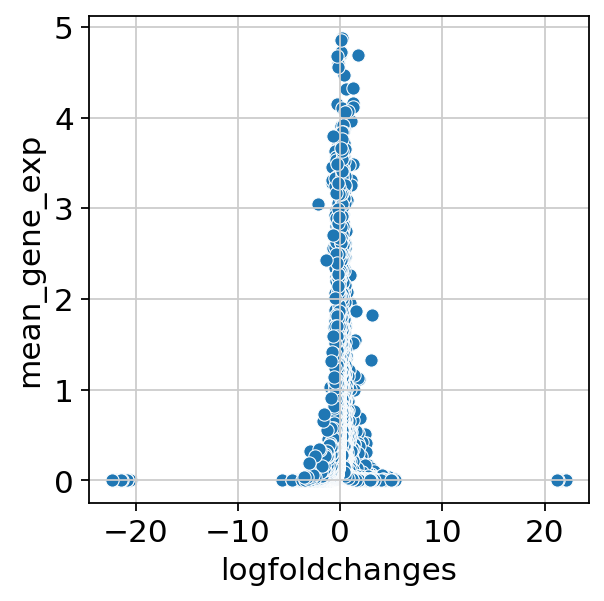

In [15]:
sns.scatterplot(data=diff_res, x='logfoldchanges',y='mean_gene_exp')

<Axes: xlabel='scores', ylabel='mean_gene_exp'>

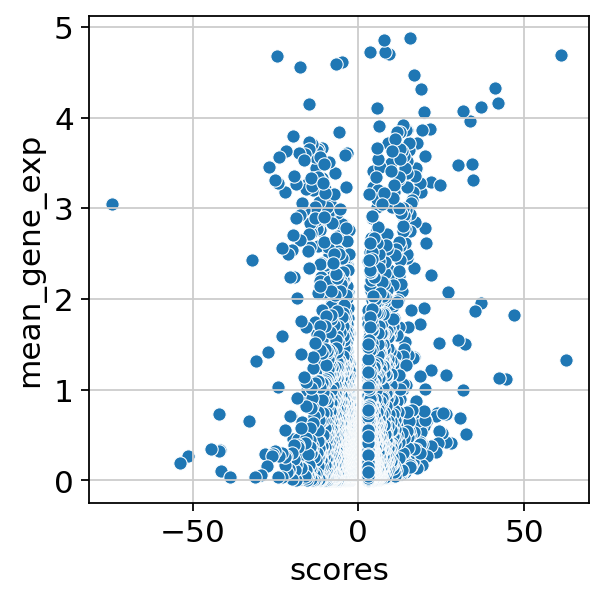

In [16]:
sns.scatterplot(data=diff_res, x='scores',y='mean_gene_exp')

# Slect genes to plot

In [18]:
display(diff_res[diff_res['names']=='NRG1'])

,group,names,scores,logfoldchanges,pvals,pvals_adj,mean_gene_exp
358,inner,NRG1,7.221292,2.908145,6.942348e-13,3.761429e-11,0.023899
4307,middle,NRG1,-4.377378,-1.542786,1.233876e-05,1.567490e-03,0.004946
8007,outer,NRG1,-7.549096,-3.101157,5.397816e-14,3.333922e-12,0.002035


In [19]:
groups

['outer', 'middle', 'inner']

In [56]:
groups = ['outer','middle','inner']
logfc_thresh = 0.1
mean_exp_thresh = 0.05

gene_lists = {}
for grp in groups:
    gene_lists[f'{grp}_up'] = np.nan
    gene_lists[f'{grp}_down'] = np.nan

for grp in groups:
    # up genes
    genes = diff_res[(diff_res['group']==grp)&\
                (diff_res['logfoldchanges'] > logfc_thresh)&\
                (diff_res['mean_gene_exp'] > mean_exp_thresh)
               ]['names']
    gene_lists[f'{grp}_up'] = list(genes)
    print(f"{grp}_up: {len(gene_lists[f'{grp}_up'])}")

    # down genes
    genes = diff_res[(diff_res['group']==grp)&\
                (diff_res['logfoldchanges'] < -logfc_thresh)
                # (res['mean_gene_exp'] > mean_exp_thresh)
               ]['names']
    gene_lists[f'{grp}_down'] = list(genes)
    print(f"{grp}_down: {len(gene_lists[f'{grp}_down'])}")

outer_up: 837
outer_down: 2790
middle_up: 151
middle_down: 373
inner_up: 2447
inner_down: 1187


In [21]:
gene_lists.keys()

dict_keys(['outer_up', 'outer_down', 'middle_up', 'middle_down', 'inner_up', 'inner_down'])

# Pathway analysis of outer_up genes

In [27]:
import gseapy as gp
pd.set_option('display.max_rows', None)

geneset_list = ['MSigDB_Hallmark_2020','KEGG_2021_Human','GO_Biological_Process_2023']

enr_res = {}
key = 'outer_up'
geneset = 'GO_Biological_Process_2023'

enr_res = gp.enrichr(gene_list=gene_lists[key],
                 gene_sets=geneset_list,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

enr_res_sel = enr_res.results[enr_res.results['Gene_set'] == geneset]
enr_res_sel = enr_res_sel[enr_res_sel['Adjusted P-value'] < 0.01]
enr_res_sel['n_genes'] = [int(x.split('/')[0]) for x in df['Overlap']]
display(enr_res_sel)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,n_genes
332,GO_Biological_Process_2023,Cytoplasmic Translation (GO:0002181),65/93,3.403945e-68,1.115473e-64,0,0,57.539554,8938.818703,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP0;R...,78
333,GO_Biological_Process_2023,Macromolecule Biosynthetic Process (GO:0009059),68/183,2.451198e-46,4.016288e-43,0,0,14.646509,1538.210583,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP0;R...,77
334,GO_Biological_Process_2023,Peptide Biosynthetic Process (GO:0043043),63/158,3.261919e-45,3.563103e-42,0,0,16.337332,1673.498457,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP0;R...,71
335,GO_Biological_Process_2023,Translation (GO:0006412),71/234,1.755861e-41,1.438489e-38,0,0,10.804274,1013.905768,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP0;R...,68
336,GO_Biological_Process_2023,Gene Expression (GO:0010467),67/296,1.382105e-30,9.058318e-28,0,0,7.194340,494.639267,RPL4;RPL5;RPL30;RPL3;RPL32;RPL31;RPL34;RPLP0;R...,68
337,GO_Biological_Process_2023,Ribonucleoprotein Complex Biogenesis (GO:0022613),29/118,6.153195e-15,3.360670e-12,0,0,7.691985,251.695621,RPL5;SNU13;RPF2;RPL7;RPS4X;FBL;RPS17;RPS16;RPS...,67
338,GO_Biological_Process_2023,Regulation Of Cell Migration (GO:0030334),54/434,7.622215e-13,3.568285e-10,0,0,3.408893,95.116768,SEMA5B;CLIC4;ROBO4;FLT1;CITED2;PTPRK;FGF2;MYLK...,65
339,GO_Biological_Process_2023,Ribosome Biogenesis (GO:0042254),29/155,1.001269e-11,4.101447e-09,0,0,5.422688,137.341326,RPL5;SNU13;RPF2;RPL7;RPS4X;FBL;RPS17;RPS16;RPS...,63
340,GO_Biological_Process_2023,Ribosomal Small Subunit Biogenesis (GO:0042274),21/84,2.390020e-11,8.702329e-09,0,0,7.802288,190.821595,NPM1;RPS7;RPS8;RPS5;RPS6;RPS3A;RPSA;SNU13;RPS4...,62
341,GO_Biological_Process_2023,Positive Regulation Of Cell Migration (GO:0030...,38/272,6.848093e-11,2.244120e-08,0,0,3.847234,90.042463,SEMA5B;CSF1R;FLT1;SEMA3C;PDGFB;ACVR1B;AIF1;THB...,54


In [30]:
'Positive Regulation Of Leukocyte'.lower()

'positive regulation of leukocyte'

# Get genes involved in cell proliferation pathway

In [36]:
pd.set_option('max_colwidth', -1)
keys_to_grep = ['cell cycle','proliferation']
mask = [any([y.lower() in x.lower() for y in keys_to_grep]) for x in enr_res_sel['Term']]
enr_res_sel[mask][['Term','n_genes']]

,Term,n_genes
343,Positive Regulation Of Cell Population Proliferation (GO:0008284),53
345,Regulation Of Cell Population Proliferation (GO:0042127),46
373,Positive Regulation Of Fibroblast Proliferation (GO:0048146),18
381,Regulation Of Endothelial Cell Proliferation (GO:0001936),15
389,Negative Regulation Of Cell Population Proliferation (GO:0008285),12
394,Regulation Of Fibroblast Proliferation (GO:0048145),9
407,Positive Regulation Of Epithelial Cell Proliferation (GO:0050679),6


In [41]:
terms_of_interest = ['Positive Regulation Of Cell Population Proliferation (GO:0008284)','Regulation Of Cell Population Proliferation (GO:0042127)']
l = list(enr_res_sel[enr_res_sel['Term'].isin(terms_of_interest)]['Genes'])
genes_of_interest = []
for g in l:
    genes_of_interest = genes_of_interest + g.split(';')
genes_of_interest = list(set(genes_of_interest))
print(len(genes_of_interest))
genes_of_interest

76


['VIPR1',
 'PHIP',
 'PPP2R5C',
 'STRN',
 'CDK6',
 'RPS4X',
 'ZNF503',
 'PIM1',
 'LIFR',
 'CDCA7L',
 'CSF1R',
 'PDPN',
 'THBS1',
 'SQLE',
 'EGLN3',
 'PDGFD',
 'HMGB2',
 'IRF6',
 'NAMPT',
 'PDCD10',
 'PTN',
 'CTBP2',
 'JUN',
 'AIF1',
 'ERBB4',
 'CDKN1A',
 'ZNF268',
 'JAK2',
 'RAPGEF2',
 'ITGB1BP1',
 'NAP1L1',
 'PDGFRB',
 'SGK1',
 'ADGRG1',
 'PDGFC',
 'CD74',
 'ZFP36L1',
 'CD200',
 'FOLR2',
 'EMILIN2',
 'MDK',
 'FGF2',
 'CCNA2',
 'PTPRK',
 'PDGFRA',
 'VEGFC',
 'WT1',
 'KDR',
 'SH3BP4',
 'KDM1A',
 'TDGF1',
 'PDGFB',
 'RPS6',
 'HMGA2',
 'RPS15A',
 'WNT5A',
 'FGF18',
 'SMARCC1',
 'NDUFS4',
 'HSPA1B',
 'CLDN5',
 'CTSH',
 'VEGFA',
 'NR4A3',
 'SFRP1',
 'RPL17',
 'KITLG',
 'HDAC2',
 'PODN',
 'HILPDA',
 'KDM4C',
 'NCK2',
 'SDCBP',
 'ALDH1A2',
 'RGCC',
 'NPM1']

# Manually curated cardiomyocyte cell cycle genes

In [44]:
cc_genes_df = pd.read_csv('./Gene_markers_CellCycle.csv')
cc_genes = list(cc_genes_df[cc_genes_df['Reference related to CM'].isna()==False]['Gene'])
cc_genes

['CDKN1A',
 'CDKN2A',
 'CDKN2B',
 'CDKN1B',
 'CDKN1C',
 'CDK1',
 'CDK2',
 'CDK4',
 'CDK6',
 'CDK7',
 'CCNA2',
 'CCNB1',
 'CCND1',
 'CCND2',
 'CCNE1',
 'CCNH',
 'YAP1',
 'TBX20']

In [63]:
# cc_genes which are statistically enriched
# up in outer side
# or down in inner side

groups = ['outer','middle','inner']
logfc_thresh = 0
mean_exp_thresh = 0

gene_lists = {}
for grp in groups:
    gene_lists[f'{grp}_up'] = np.nan
    gene_lists[f'{grp}_down'] = np.nan

for grp in groups:
    # up genes
    genes = diff_res[(diff_res['group']==grp)&\
                (diff_res['logfoldchanges'] > logfc_thresh)&\
                (diff_res['mean_gene_exp'] > mean_exp_thresh)
               ]['names']
    gene_lists[f'{grp}_up'] = list(genes)
    print(f"{grp}_up: {len(gene_lists[f'{grp}_up'])}")

    # down genes
    genes = diff_res[(diff_res['group']==grp)&\
                (diff_res['logfoldchanges'] < -logfc_thresh)
                # (res['mean_gene_exp'] > mean_exp_thresh)
               ]['names']
    gene_lists[f'{grp}_down'] = list(genes)
    print(f"{grp}_down: {len(gene_lists[f'{grp}_down'])}")

set(cc_genes).intersection(gene_lists['outer_up']+gene_lists['inner_down'])

outer_up: 1058
outer_down: 2798
middle_up: 157
middle_down: 376
inner_up: 2757
inner_down: 1207


{'CCNA2', 'CDK1', 'CDK2', 'CDK6', 'CDKN1A', 'CDKN1C'}

In [61]:
diff_res[diff_res['names']=='CDK2']

,group,names,scores,logfoldchanges,pvals,pvals_adj,mean_gene_exp
3035,inner,CDK2,-3.341328,-0.284661,0.000841,0.009755,0.151074


# Plot genes

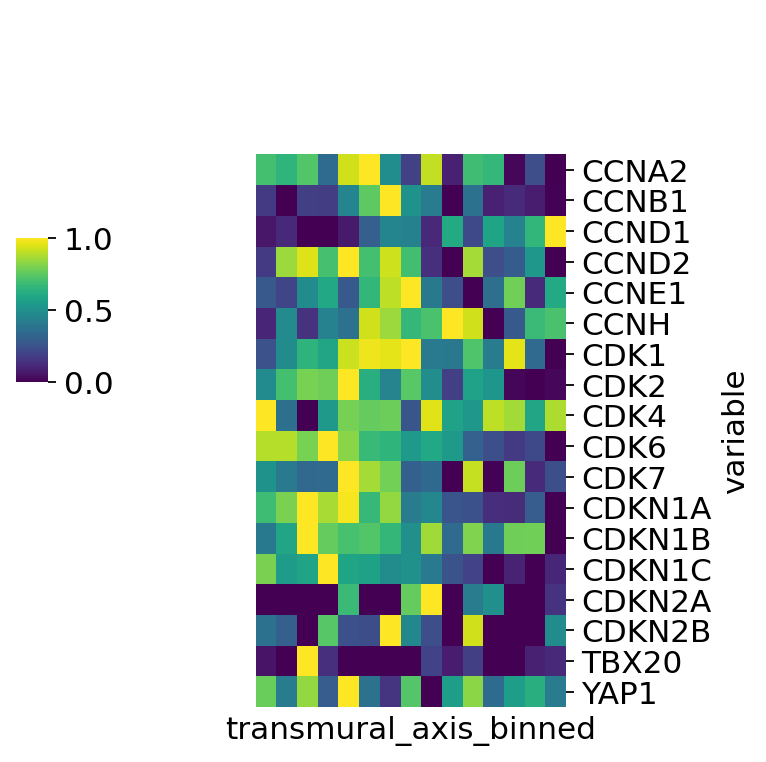

In [54]:
tissueaxis.plot_axis(adata_oct,
              axis_col='transmural_axis',
              n_bin=15,
              feature_type='gene', # 'gene' or 'celltype'
              features_to_plot=cc_genes,
              features_to_remove=None,
              threshold_express_prop=None, # at quantile=0.9
              threshold_cell_abundance=None, # at quantile=0.9
              correlation=False,
              min_max_scale=True,
              row_cluster=False,
              figsize=(4,5),
              cbar_pos=(-0.2, 0.5, 0.05, 0.18),
              cmap='viridis',
          xticklabels=False,
          yticklabels=True,
              title=None,
              return_feature = False,
                     save=f'{figdir}/tm-axis_OCT_genes_CM-cell-cycle.pdf',
    save_dpi=300,
             )